<center><h1>Identifying a Neutrophil-Associated Gene Signature</h1>
    <h3> Authors: Debashis Sahoo and Rohan Subramanian </h3></center>

<br>

<p><center>This notebook is used to find a list of genes that can be used as universal neutrophil markers and predict neutrophil counts from whole blood sequencing data. We apply a previously published method using Boolean equivalence relationships combined with additional filtering steps.</center></p>

# Table of contents

1. [Gene Signature](#genesignature)

 [Step 1: Gene X high ⇒ FCGR3A high](#step1)

 [Step 2: Calculate percentiles](#step2)

 [Step 3: Filtering](#step3)

 [Step 4: Boolean Equivalences](#step4)

 [Step 5: Filtering](#step5)

 [Step 6: Filtering by correlation with neutrophil counts](#step6)


 2. [Application](#validation)

 2.1 [FCGR3A does not perform well](#21)

 2.2 [Validate composite score](#22)

 2.3 [Validate individual genes](#23)

 2.4 [Outliers](#24)

 2.5 [Specificity to neutrophils](#25)
 
 2.6 [Prediction of neutrophils](#26)

In [22]:
# IMPORT STATEMENTS
import os
import sys
sys.path.append("/booleanfs2/sahoo/Hegemon/")
sys.path = ["/booleanfs2/sahoo/BoNE/"] + sys.path

import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import numpy.ma as ma
import scipy
import pandas as pd

import bone
%load_ext autoreload

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import scripts and important functions
sys.path.insert(0, os.getcwd()+"/Scripts")
from neuAnalysis import NeuAnalysis
from ViolinPlot import *

def getRelStatsJava(ana, id1, order, sthr=3.0, pthr=0.1):
    ofh = open(".arrorder", "w")
    for i in order:
        ofh.write(ana.headers[i] + "\n")
    ofh.close()
    from subprocess import check_output
    cmd = ['java', '-cp', '/booleanfs2/sahoo/Hegemon',
           'tools.Hegemon', 'Bool', ana.h.getPre(),
           id1, '.arrorder']
    result = check_output(cmd, input='')
    l1 = result.decode('utf-8').split('\n')
    res = {}
    for line in l1:
        if line == '':
            continue
        k = line.split('\t')
        bs = bone.np.array([k[2:6], k[2:6], k[6:10], k[10:]]).astype(bone.np.float)
        rel = bone.hu.getBooleanRelationType(bs, sthr, pthr)
        if rel[0] not in res:
            res[rel[0]] = {}
        res[rel[0]][k[1]] = rel[1]
    return res

ran NeuAnalysis
ran ViolinPlot.py


## 1. Gene Signature <a name="genesignature"></a>

### Step 1: Gene X high ⇒ FCGR3A high <a name="step1"></a>

Search for genes following the Boolean relationship *Gene X high => FCGR3A high* in the global human dataset (25955 pooled GPL570 samples)

In [3]:
ana = NeuAnalysis()
ana.getGlobal()
id1 = list(ana.h.getIDs("FCGR3A").keys())[0]
print(id1)
fres1 = getRelStatsJava(ana, id1, ana.order, sthr=3, pthr=0.1)
print(len(fres1[2]))

Human U133 Plus 2.0 (n = 25955)
GSE119087 http://hegemon.ucsd.edu/Tools/explore.php?key=global&id=GL1
25955 [9780, 9272, 2144, 1533, 1383, 194, 96, 592, 4, 913, 44] GSE119087 http://hegemon.ucsd.edu/Tools/explore.php?key=global&id=GL1 GL1
204006_s_at
94


### Step 2: Calculate percentiles <a name="step2"></a>

<p>Calculate the percentile of expression values for each gene in neutrophils, *i.e.* how much a gene is underexpressed or overexpressed across neutrophil samples in the global dataset. If gene is expressed at the Stepminer threshold (neither high nor low), it is the 0th percentile. If the gene has the maximum expression value among neutrophils then it is assigned the 100th percentile, and likewise -100 for the minimum.</p>

<p>A Python method is outlined below (much slower), as well as a faster method of reading values computed efficiently using Scripts/percentile.cpp</p>

In [ ]:
ana = NeuAnalysis()
ana.getGlobalNeu()
tn = 1
fp = ana.h.fp;
fp.seek(0, 0);
head = fp.readline();
index = 0
rhash = {}
for line in fp:
    ll = line.split("\t")
    v1 = [float(ll[i]) for i in ana.order]
    v2 = [float(ll[i]) for i in ana.state[tn]]
    m2 = bone.np.mean(v2)
    thr = ana.h.getThrData(ll[0])
    v1_hi = [k for k in v1 if k > thr[0]]
    v1_lo = [k for k in v1 if k <= thr[0]]
    if m2 > thr[0]:
        perc = scipy.stats.percentileofscore(v1_hi, m2)
    else:
        perc = -scipy.stats.percentileofscore(v1_lo, m2)
    rhash[ll[0]] = perc
    index += 1
    if (index % 1000) == 0:
        print(index)

In [4]:
rhash = bone.pd.read_csv("Data/human-gpl570-neu-perc.txt", sep="\t", index_col=0)

### Step 3: Filtering by percentile <a name="step3"></a>
We can now filter the first list by keeping only the genes above the 90th percentile of expression values in neutrophils.

In [5]:
cid1 = [k for k in fres1[2] if k in rhash['Percentile'] and rhash['Percentile'][k] > 90]
c1 = [ana.h.getSimpleName(k) for k in cid1]
c1 = [k for k in bone.hu.uniq(c1) if k != '---']
print(" ".join(c1))
len(cid1)

GPR97 SIRPB1 NLRP12 HCG27 FCGR2A FCGR3B FPR1 TNFRSF10C IL8RB IL8RA LILRA1 MMP25 CCR3 CR1 SLC11A1 MGC31957 EMR3 FPR2 CEACAM3 PILRA SIGLEC5 TLR8 FFAR2 CLEC4A CLEC4E OR52K3P NFAM1


36

### Step 4: Boolean equivalences <a name="step3"></a>

We now identify genes which have Boolean equivalences with the 36 genes obtained above in the same global dataset, this time limited only to samples from liquid tissues such as blood.

In [14]:
ana = NeuAnalysis()
ana.getGlobal()
cidres = []
for id1 in cid1:
    print(id1, ana.h.getSimpleName(id1))
    order = [i for i in ana.h.aRange() if ana.atype[i] == 'liquid']
    cidres1 = getRelStatsJava(ana, id1, order, sthr=3, pthr=0.1)
    print([(k, len(cidres1[k])) for k in cidres1])
    cidres += [cidres1]

Human U133 Plus 2.0 (n = 25955)
GSE119087 http://hegemon.ucsd.edu/Tools/explore.php?key=global&id=GL1
25955 [9780, 9272, 2144, 1533, 1383, 194, 96, 592, 4, 913, 44] GSE119087 http://hegemon.ucsd.edu/Tools/explore.php?key=global&id=GL1 GL1
1553723_at GPR97
[(0, 39697), (4, 10123), (3, 4667), (2, 137), (5, 43), (1, 9)]
1554624_a_at SIRPB1
[(0, 47535), (3, 615), (4, 1354), (2, 3317), (1, 1764), (5, 63), (6, 28)]
1554952_s_at NLRP12
[(0, 45641), (4, 3492), (3, 1631), (2, 2470), (1, 1302), (6, 44), (5, 96)]
1559050_at HCG27
[(0, 48363), (4, 3882), (3, 1853), (2, 375), (1, 163), (5, 35), (6, 5)]
1563509_at ---
[(0, 47419), (4, 2360), (2, 2567), (3, 934), (1, 1360), (5, 26), (6, 10)]
1565674_at FCGR2A
[(0, 49725), (3, 640), (2, 2269), (4, 1206), (1, 806), (6, 18), (5, 12)]
204007_at FCGR3B
[(0, 50892), (4, 1784), (3, 854), (2, 697), (1, 447), (5, 2)]
205119_s_at FPR1
[(0, 47540), (2, 3053), (3, 582), (4, 964), (1, 2476), (5, 53), (6, 8)]
206222_at TNFRSF10C
[(0, 43689), (4, 7310), (3, 3284), 

In [28]:
x = [i for k in cidres for i in k[5]]
len(np.unique(x))

914

### Step 5: Filtering by percentile and dynamic range <a name="step5"></a>
We filter the results of Boolean equivalence by keeping only genes above the 90th percentile of expression values in neutrophils and with a dynamic range of expression more than 4.

In [17]:
ana = NeuAnalysis()
ana.getGlobal()
df = bone.pd.read_csv(ana.h.rdataset.getVInfo(), sep="\t", index_col=0)
dr = bone.pd.to_numeric(df['97.5%']) - bone.pd.to_numeric(df['2.5%'])
c1 = [i for k in cidres for i in k[5] if rhash['Percentile'][i] > 98 and dr[i] > 4]
c1 = [ana.h.getSimpleName(k) for k in c1]
c1 = [k for k in bone.hu.uniq(c1) if k != '---']
print(len(c1))
print(" ".join(c1))

Human U133 Plus 2.0 (n = 25955)
GSE119087 http://hegemon.ucsd.edu/Tools/explore.php?key=global&id=GL1
25955 [9780, 9272, 2144, 1533, 1383, 194, 96, 592, 4, 913, 44] GSE119087 http://hegemon.ucsd.edu/Tools/explore.php?key=global&id=GL1 GL1
30
KCNJ15 TLR4 FCGR3A PAK1 WDFY3 UBE2D1 FLJ11151 CLEC4E DOCK5 MEGF9 ABHD5 LIMK2 BCL6 IL13RA1 LST1 NAMPT GPR109B MBOAT7 DYSF OGFRL1 ARHGAP26 BASP1 PYGL TNFRSF1A HCK CFLAR NCF2 CEBPB MIRN21 BID


### Step 6: Filtering by correlation with neutrophil counts  <a name="step6"></a>

We can use Altman 2019 asthma Blood (GSE115823, n = 511) as a training dataset for a final filtering step if the correlation with neutrophil counts and log2(neutrophil counts) is greater than 7.

Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV1

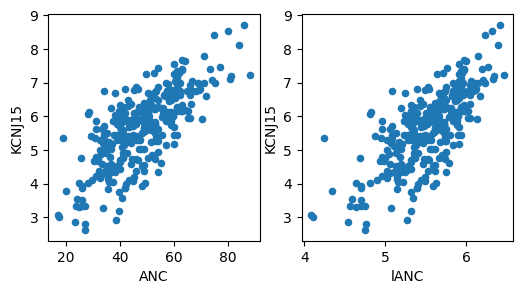

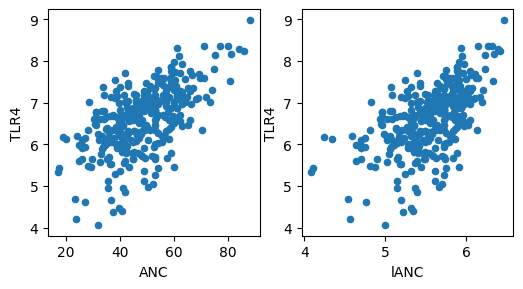

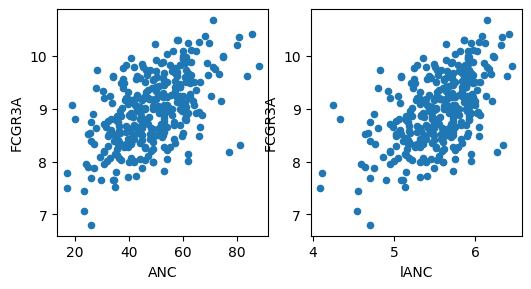

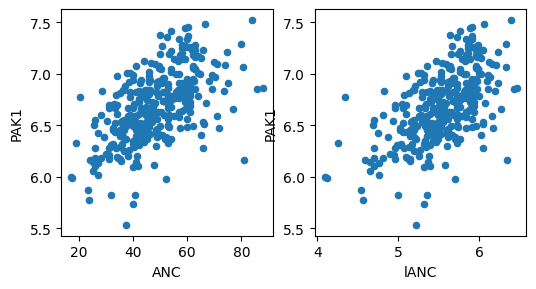

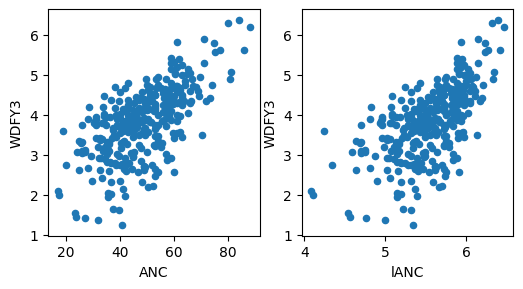

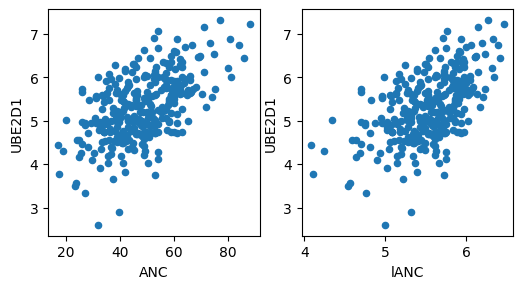

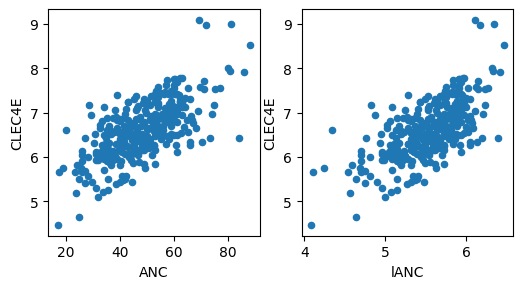

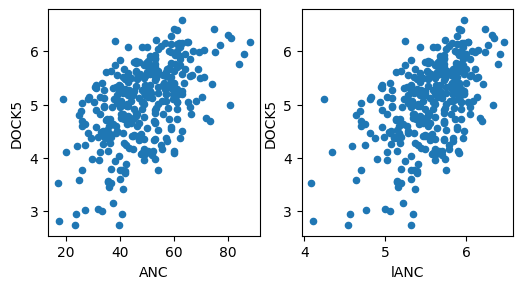

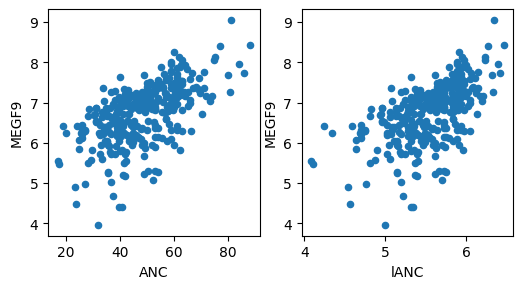

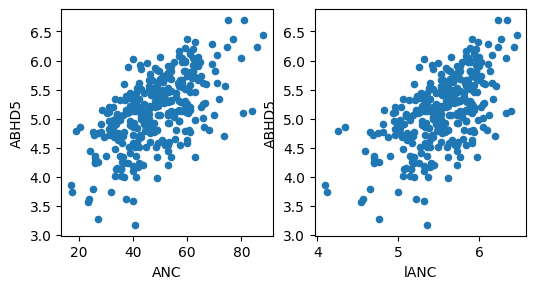

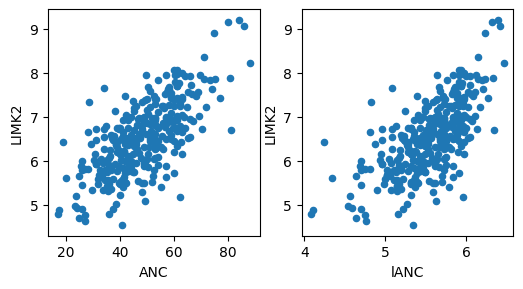

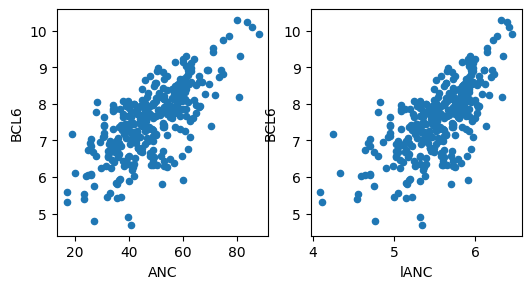

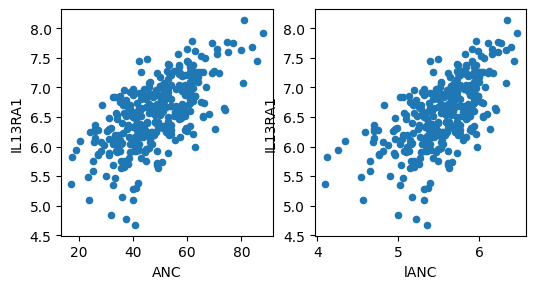

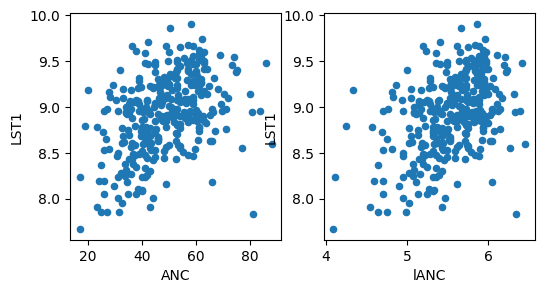

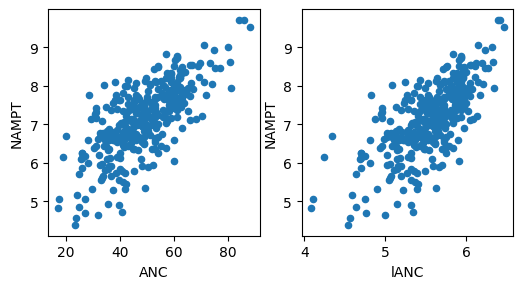

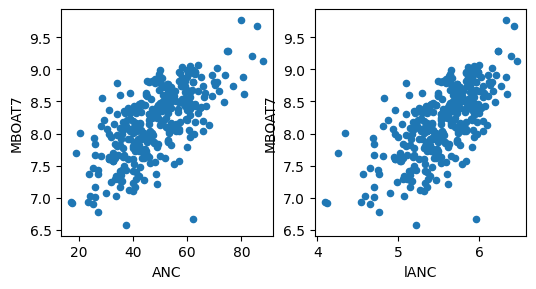

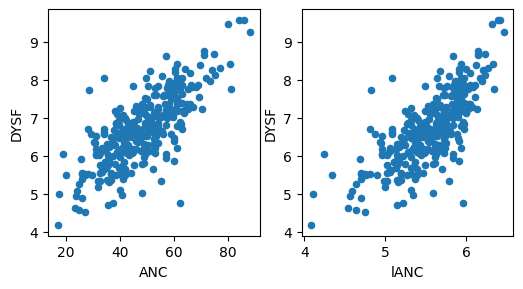

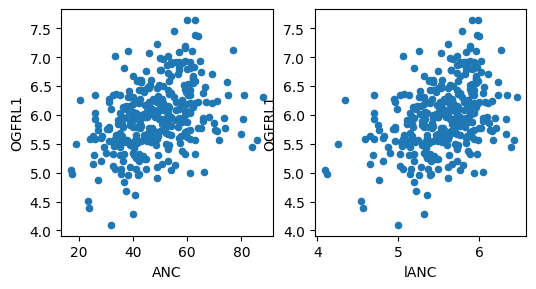

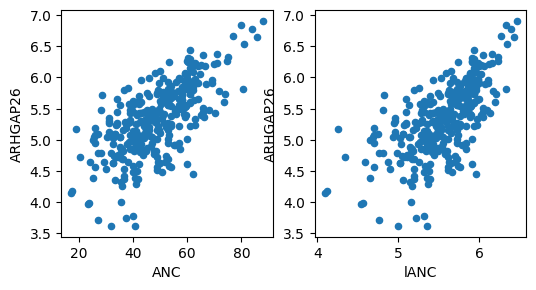

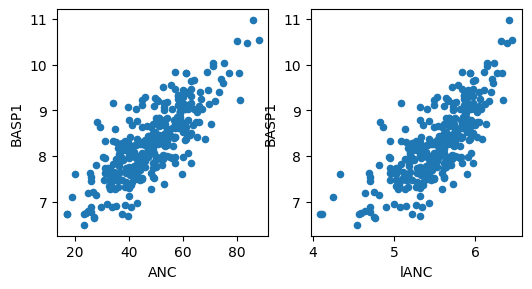

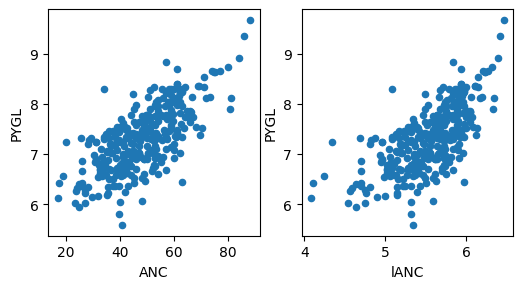

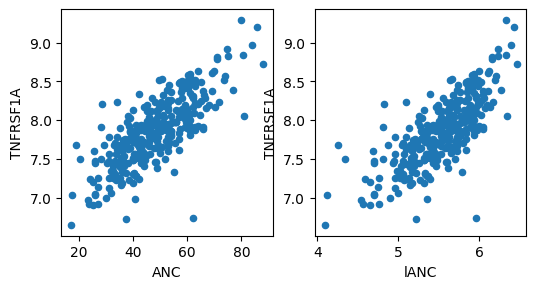

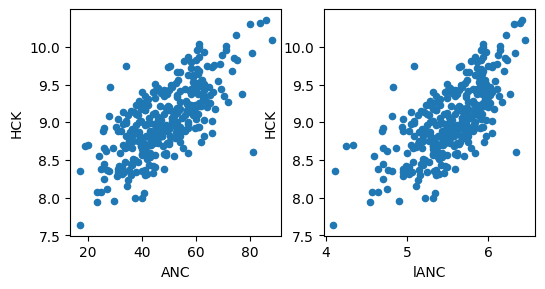

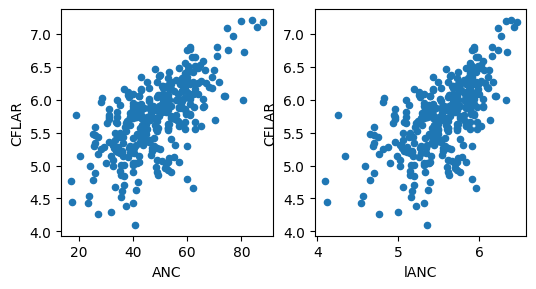

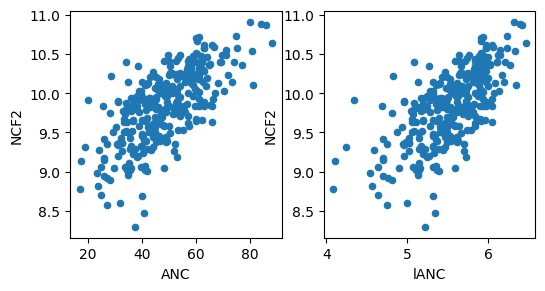

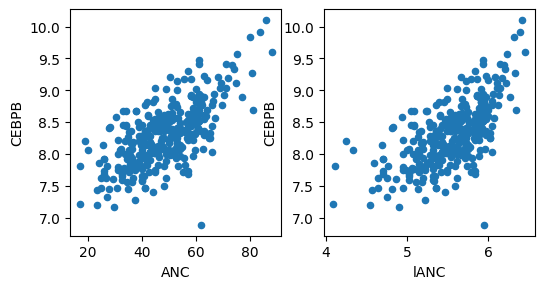

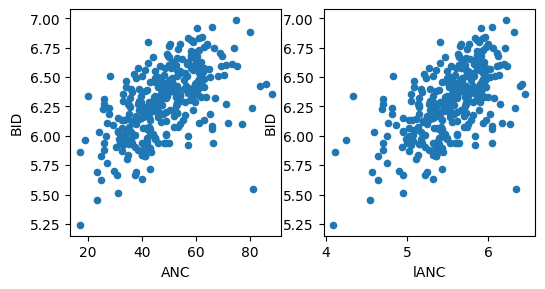

In [62]:
list1 = ['KCNJ15', 'TLR4', 'FCGR3A', 'PAK1', 'WDFY3', 'UBE2D1', 'FLJ11151',
         'CLEC4E', 'DOCK5', 'MEGF9', 'ABHD5', 'LIMK2', 'BCL6', 'IL13RA1', 'LST1', 
         'NAMPT', 'GPR109B', 'MBOAT7', 'DYSF', 'OGFRL1', 'ARHGAP26', 'BASP1',
         'PYGL', 'TNFRSF1A', 'HCK', 'CFLAR', 'NCF2', 'CEBPB', 'MIRN21', 'BID']
res = []
id1 = whole_dataset[0]
for g1 in list1:
    ana.getSurvival(id1[0])
    wbc = ana.h.getSurvName(id1[1])
    expr = ana.h.getExprData(g1)
    if expr is None:
        continue
    df = pd.DataFrame()
    ahash = {'NA':1, 'Not Applicable':1, 'Data Not Available':1,
             'unknown':1, 'Missing Data':1}
    df['ANC'] = pd.to_numeric(["" if k.strip() in ahash else k for k in wbc[2:]])
    df['lANC'] = np.log(df['ANC'])/np.log(2)
    df[g1] = pd.to_numeric(expr[2:])
    fig,axlist = bone.plt.subplots(ncols=2, nrows=1, figsize=(6,3), dpi=100)
    df.plot.scatter('ANC', g1, ax=axlist[0])
    df.plot.scatter('lANC', g1, ax=axlist[1])
    corr1 = ma.corrcoef(ma.masked_invalid(df[g1]), ma.masked_invalid(df['ANC']))[0][1]
    corr2 = ma.corrcoef(ma.masked_invalid(df[g1]), ma.masked_invalid(df['lANC']))[0][1]
    res += [(corr1, corr2, g1)]

In [63]:
[k[2] for k in res if k[0] > 0.7 and k[1] > 0.7]

['KCNJ15', 'NAMPT', 'DYSF', 'BASP1', 'TNFRSF1A']

## 2. Application <a name="validation"></a>

This is a list of whole blood, nasal and sputum RNA-sequencing datasets avaliable in our Hegemon database with associated neutrophil counts.

In [221]:
whole_dataset = [
    ["COV192.2", "c blood.neutrophil.differential"],
    ["COV192", "c nasal.neutrophil.percentage"],
    ["COV247", "c anc"], ["COV257", "c anc"],
    ["COV314", "c per neutrophils"],
    ["COV314", "c abs neutrophils"],
    ["MACV296", 'c blood neutrophil count (cells/ul)'],
    ["MACV296", 'c sputum differential neutrophil count %'],
    ["MACV305", 'c neutrophl_pct'], 
    ["MACV306", 'c neutrophils_count'],
    ["MACV307", 'c neutrophil_count'],
    ["MACV307", 'c neutrophil_percent'],
    ["MACV308", 'c neu (10e9/l)'],
    ["MACV309", 'c neutrophil'],
    ["MACV309", 'c neutrophils'],
    ["MACV310", 'c neutrophil count'],
    ['COV429', 'c Neutrophil'],
    ['MACV331', 'c diff cell count neutrophils (%)'],
    ['MACV332', 'c neutrophils']
]

In [186]:
from matplotlib.backends.backend_pdf import PdfPages
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")

def findCorr(gene, showplots=False, fname=None, save=False):
    res = {}
    fig,axs = plt.subplots(nrows=5, ncols=4, dpi=100)
    fig.set_size_inches(15, 20)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.5)

    
    for id1, ax in zip(whole_dataset, axs.flatten()):
        ana = NeuAnalysis()
        ana.getSurvival(id1[0])
        wbc = ana.h.getSurvName(id1[1])
        expr = ana.h.getExprData(gene)
        df = pd.DataFrame()
        ahash = {'NA':1, 'Not Applicable':1, 'Data Not Available':1,
                 'unknown':1, 'Missing Data':1}
        df['ANC'] = pd.to_numeric(["" if k.strip() in ahash else k for k in wbc[2:]])
        df['Exp'] = pd.to_numeric(expr[2:])
        corr1 = ma.corrcoef(ma.masked_invalid(df['Exp']), ma.masked_invalid(df['ANC']))[0][1]
        res[id1[0]] = corr1
        
        if showplots:
            # fig,ax = plt.subplots(figsize=(3,3), dpi=100)
            h = hu.Hegemon(db.getDataset(id1[0]))
            name = h.getTitle().split("(")[1]
            title = f'{np.round(corr1, 2)} ({name}'
            # plt.title(title1)
            df.plot.scatter('ANC', 'Exp', ax=ax, title=title, color='b')
            ax.set(xlabel=None, ylabel=None)
    
    fig.suptitle(f"Neutrophil Counts vs. {gene} Expression")
    fig.delaxes(axs[4,3])
        
    if save:
        pdf = PdfPages(fname)
        pdf.savefig(fig)
        pdf.close()
    
    return fig, res

<a id="21"></a>

### 2.1 FCGR3A does not perform well

First, we show that many established markers such as FCGR3A are not correlated with neutrophil counts.

In [30]:
fcgr3aDict = findCorr("FCGR3A")

Altman 2019 asthma Nasal (n = 523)
GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192
0 [0, 0] GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192 COV192
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Wright 2018 kd 2 (n = 692)
GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247
0 [0, 0] GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247 COV247
Burns 2020 kd tpm (n = 121)
Burns http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257
0 [0, 0] Burns http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257 COV257
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.ed

In [35]:
np.mean(list(fcgr3aDict.values()))

0.09488449651449776

Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Nasal (n = 523)
GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192
0 [0, 0] GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192 COV192
Wright 2018 kd 2 (n = 692)
GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247
0 [0, 0] GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247 COV247
Burns 2020 kd tpm (n = 121)
GSE178491 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257
0 [0, 0] GSE178491 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257 COV257
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon

(<Figure size 1500x2000 with 19 Axes>,
 {'COV192.2': 0.5432798981413257,
  'COV192': 0.4714332645987317,
  'COV247': -0.031078751682128855,
  'COV257': 0.13803839199792878,
  'COV314': 0.009351411943819402,
  'MACV296': -0.33933978995142733,
  'MACV305': 0.032755361490492275,
  'MACV306': -0.05693190248833486,
  'MACV307': 0.11090576399849918,
  'MACV308': -0.251050046641893,
  'MACV309': -0.16319313437405733,
  'MACV310': 0.43339389346335155,
  'COV429': 0.17216790291599202,
  'MACV331': 0.08999717437703962,
  'MACV332': 0.26353800992812765})

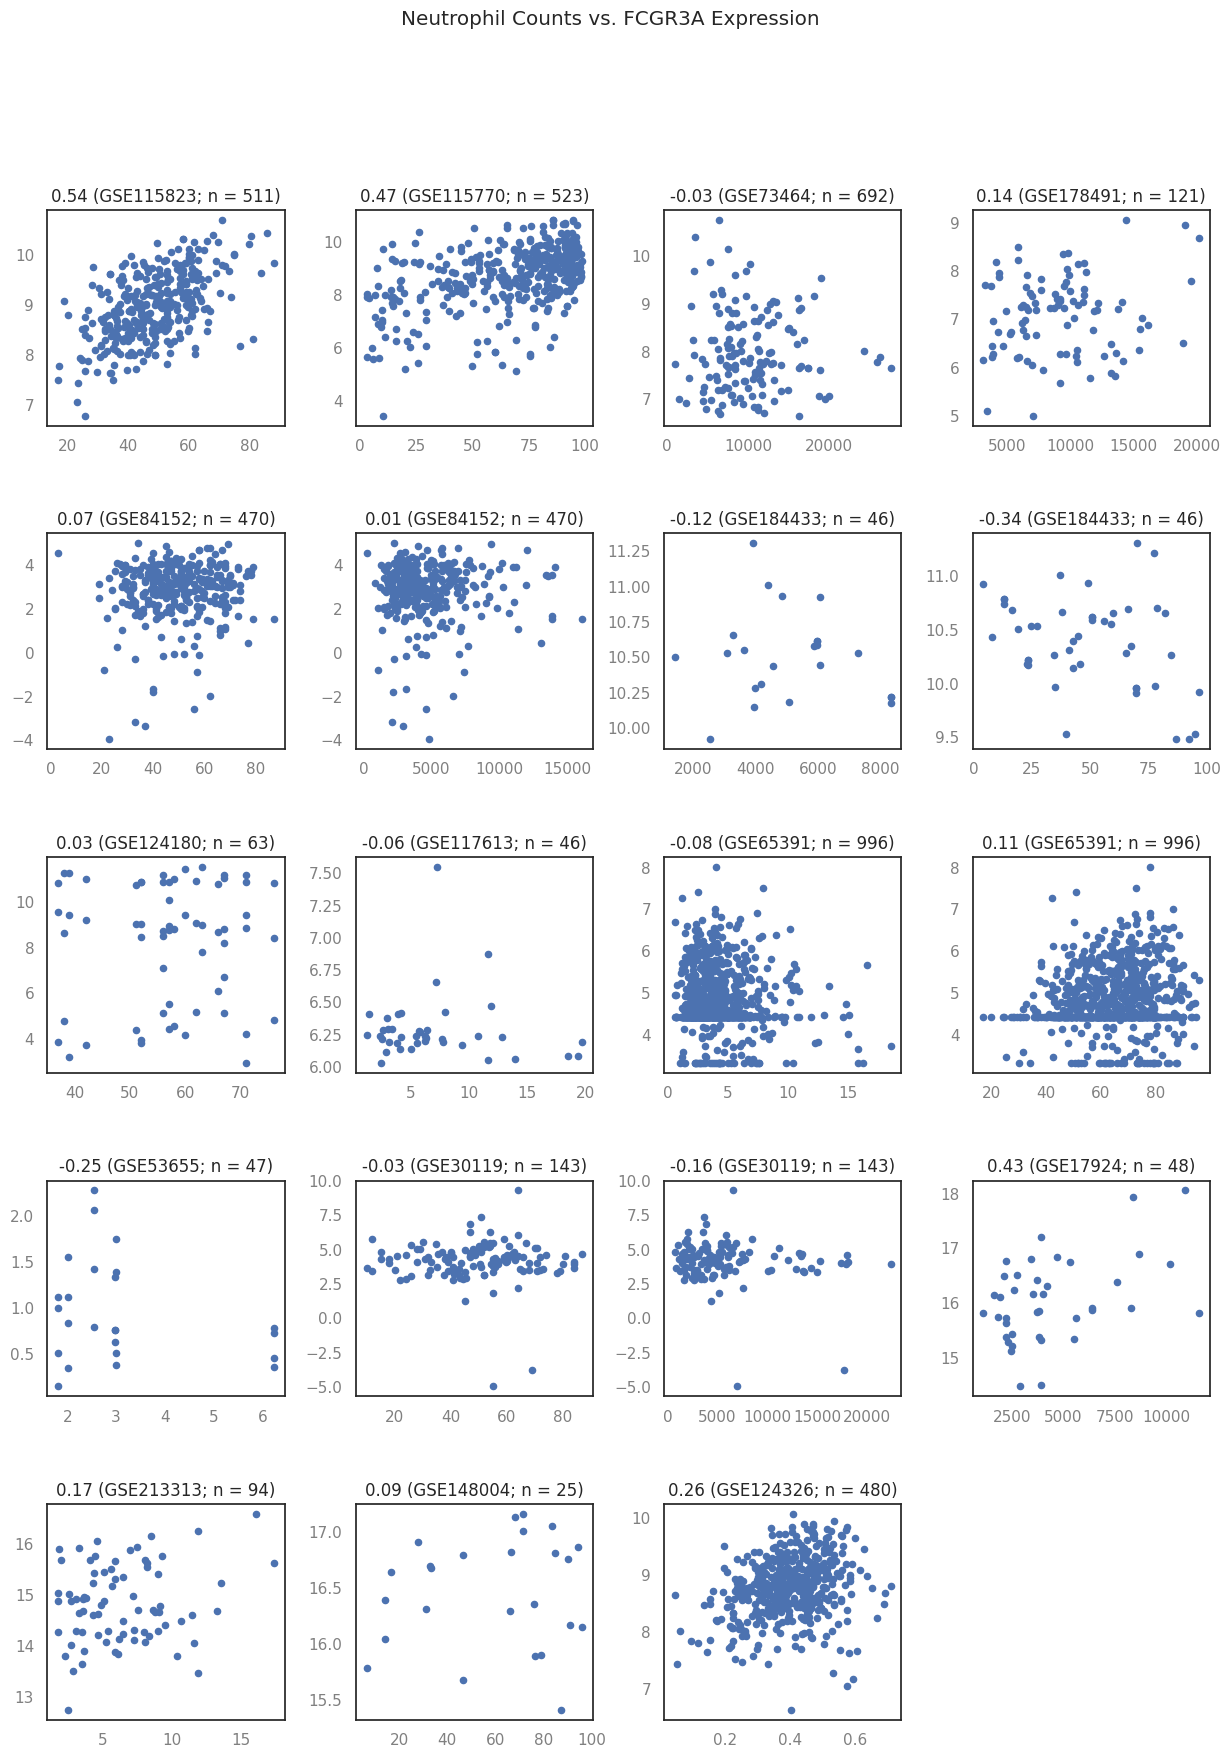

In [181]:
findCorr("FCGR3A", showplots=True, fname="Figures/fcgr3a.pdf", save=True)

<a id="22"></a>

### 2.2 Validate Composite Score

Finally, we can determine if a composite score using these 5 genes is correlated with neutrophil counts in the remaining datasets.

In [ ]:
res = {}
for id1 in whole_dataset[1:]:
    ana = NeuAnalysis()
    ana.getSurvival(id1[0])
    wbc = ana.h.getSurvName(id1[1])
    wt1, l1 = [1], [['KCNJ15', 'NAMPT', 'DYSF', 'BASP1', 'TNFRSF1A']]
    ana.order = ana.h.aRange()
    ana.orderData(l1, wt1)
    expr = ["", ""] + list(ana.f_ranks)
    df = pd.DataFrame()
    ahash = {'NA':1, 'Not Applicable':1, 'Data Not Available':1,
             'unknown':1, 'Missing Data':1}
    df['ANC'] = pd.to_numeric(["" if k.strip() in ahash else k for k in wbc[2:]])
    df['Exp'] = pd.to_numeric(expr[2:])
    fig,ax = plt.subplots(figsize=(3,3), dpi=100)
    df.plot.scatter('ANC', 'Exp', ax=ax)
    corr1 = ma.corrcoef(ma.masked_invalid(df['Exp']), ma.masked_invalid(df['ANC']))[0][1]
    res[id1[0]] = corr1
np.mean(list(res.values()))

In [70]:
np.mean(list(res.values()))

0.5584158619431243

In [71]:
res

{'COV192': 0.7154936988038754,
 'COV247': 0.460967458603545,
 'COV257': 0.43948992053357366,
 'COV314': 0.5547669810341004,
 'MACV296': 0.5259440256501217,
 'MACV305': 0.02541408784784404,
 'MACV306': 0.4766356993319098,
 'MACV307': 0.765614525603086,
 'MACV308': 0.6158440431516383,
 'MACV309': 0.6668507243428653,
 'MACV310': 0.348071197567793,
 'COV429': 0.6083829688836834,
 'MACV331': 0.9053562542997257,
 'MACV332': 0.7089904815499787}

Generate and save plots:

Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
[5]
Altman 2019 asthma Nasal (n = 523)
GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192
0 [0, 0] GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192 COV192
[5]
Wright 2018 kd 2 (n = 692)
GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247
0 [0, 0] GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247 COV247
[8]
Burns 2020 kd tpm (n = 121)
GSE178491 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257
0 [0, 0] GSE178491 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257 COV257
[5]
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
[8]
Gideon 2016 tb (n = 470)
GSE

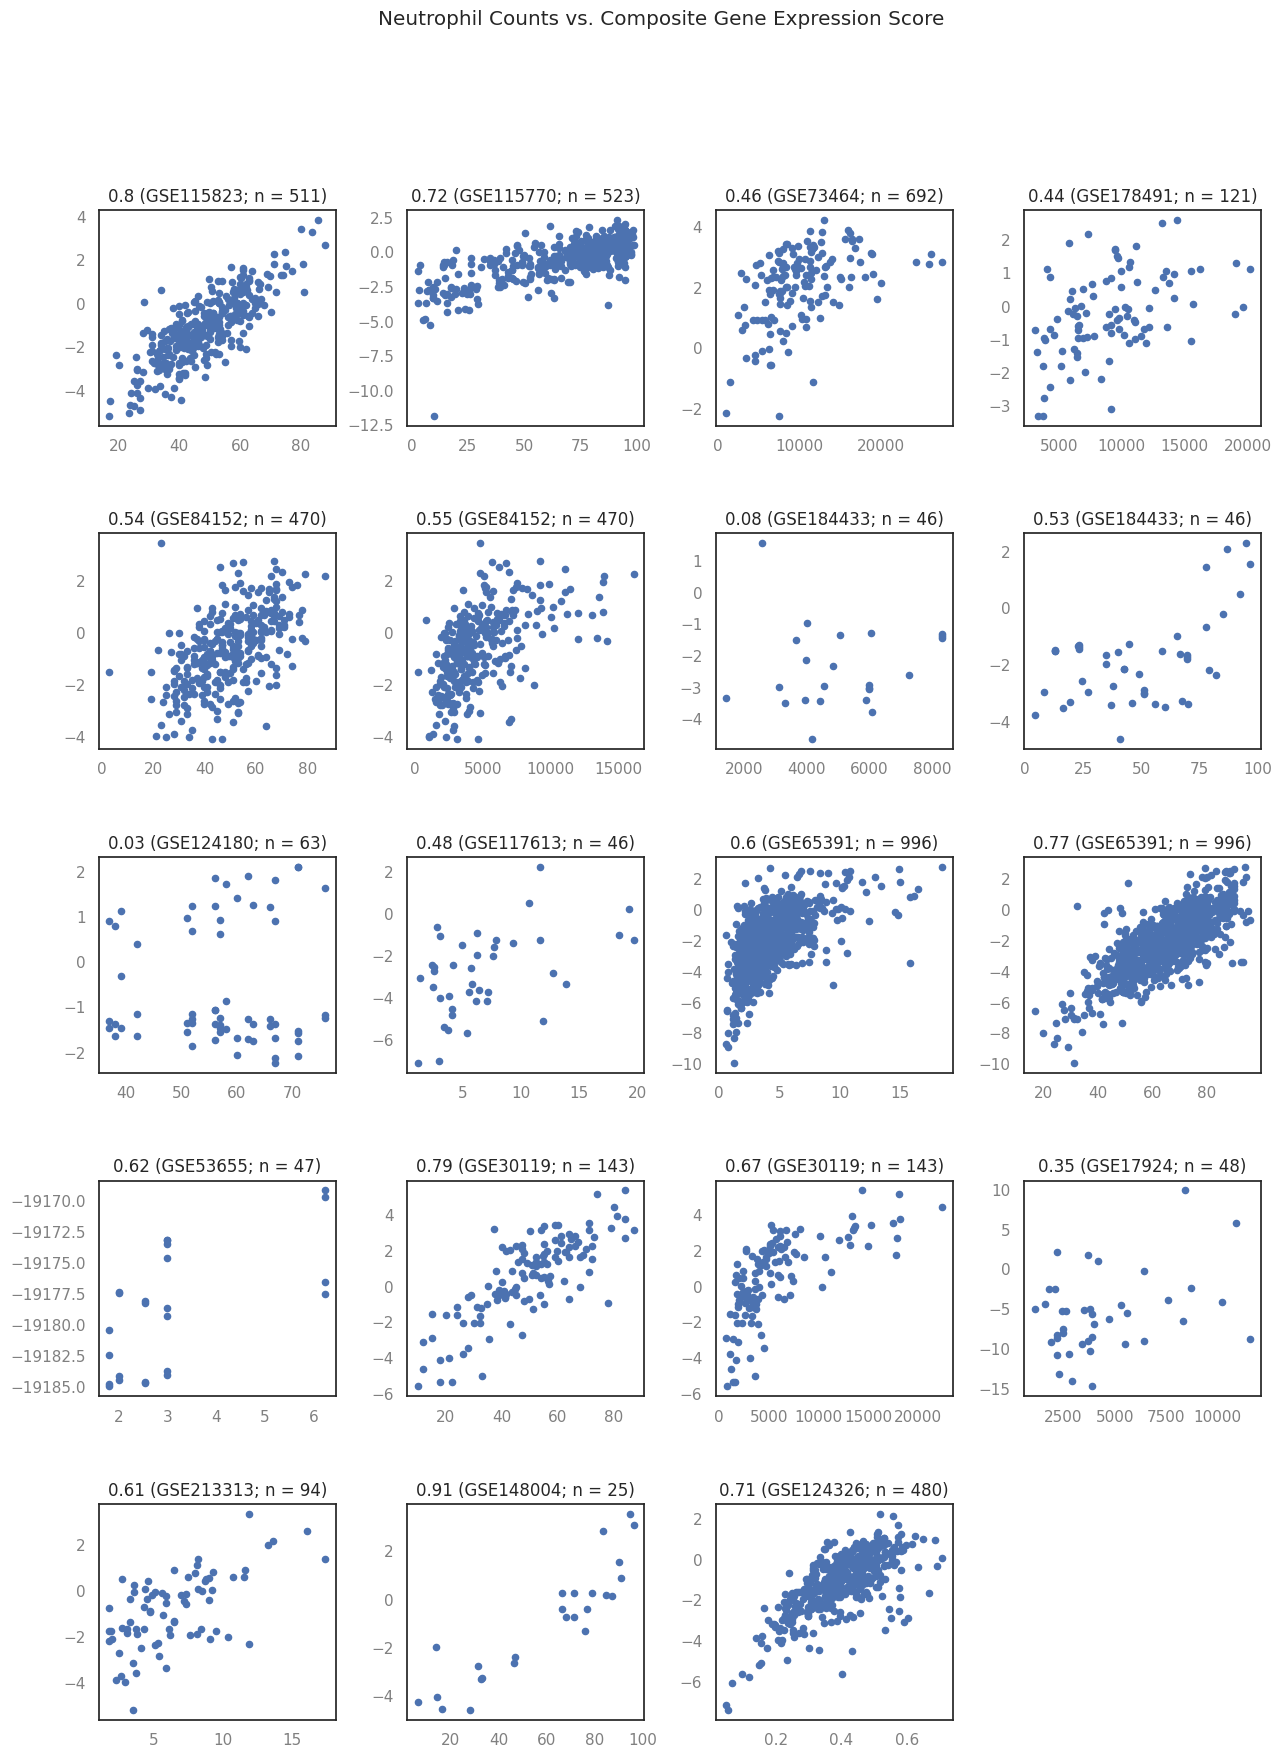

In [192]:
res = {}
fig,axs = plt.subplots(nrows=5, ncols=4, dpi=100)
fig.set_size_inches(15, 20)
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.5)
    
for ax,id1 in zip(axs.flatten(), whole_dataset):
    
    ana = NeuAnalysis()
    ana.getSurvival(id1[0])
    wbc = ana.h.getSurvName(id1[1])
    wt1, l1 = [1], [['KCNJ15', 'NAMPT', 'DYSF', 'BASP1', 'TNFRSF1A']]
    ana.order = ana.h.aRange()
    ana.orderData(l1, wt1)
    expr = ["", ""] + list(ana.f_ranks)
    df = pd.DataFrame()
    ahash = {'NA':1, 'Not Applicable':1, 'Data Not Available':1,
             'unknown':1, 'Missing Data':1}
    df['ANC'] = pd.to_numeric(["" if k.strip() in ahash else k for k in wbc[2:]])
    df['Exp'] = pd.to_numeric(expr[2:])
    corr1 = ma.corrcoef(ma.masked_invalid(df['Exp']), ma.masked_invalid(df['ANC']))[0][1]
    res[id1[0]] = corr1

    h = hu.Hegemon(db.getDataset(id1[0]))
    name = h.getTitle().split("(")[1]
    title = f'{np.round(corr1, 2)} ({name}'
    df.plot.scatter('ANC', 'Exp', ax=ax, title=title, color='b')
    ax.set(xlabel=None, ylabel=None)

fig.suptitle(f"Neutrophil Counts vs. Composite Gene Expression Score")
fig.delaxes(axs[4,3])

pdf = PdfPages("Figures/composite.pdf")
pdf.savefig(fig)
pdf.close()

<a id="23"></a>

### 2.3 Validate Individual Genes

Some individual genes in the list also perform well.

In [75]:
basp1Dict = findCorr("BASP1")

Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Nasal (n = 523)
GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192
0 [0, 0] GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192 COV192
Wright 2018 kd 2 (n = 692)
GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247
0 [0, 0] GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247 COV247
Burns 2020 kd tpm (n = 121)
Burns http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257
0 [0, 0] Burns http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257 COV257
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.ed

In [80]:
basp1Dict

{'COV192.2': 0.7874198386614021,
 'COV192': 0.6260725852853619,
 'COV247': 0.4236416358309857,
 'COV257': 0.4333654447873061,
 'COV314': 0.5295778897779485,
 'MACV296': 0.45052335308854985,
 'MACV305': 0.03293101933002991,
 'MACV306': 0.35279990121396404,
 'MACV307': 0.674844333729102,
 'MACV308': 0.4555525280559095,
 'MACV309': 0.6559739275030584,
 'MACV310': 0.2721484743273527,
 'COV429': 0.6430039288214507,
 'MACV331': 0.7814211632494673,
 'MACV332': 0.6995119371987663}

Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Altman 2019 asthma Nasal (n = 523)
GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192
0 [0, 0] GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192 COV192
Wright 2018 kd 2 (n = 692)
GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247
0 [0, 0] GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247 COV247
Burns 2020 kd tpm (n = 121)
GSE178491 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257
0 [0, 0] GSE178491 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257 COV257
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon

(<Figure size 1500x2000 with 19 Axes>,
 {'COV192.2': 0.7874198386614021,
  'COV192': 0.6260725852853619,
  'COV247': 0.4236416358309857,
  'COV257': 0.4333654447873061,
  'COV314': 0.5295778897779485,
  'MACV296': 0.45052335308854985,
  'MACV305': 0.03293101933002991,
  'MACV306': 0.35279990121396404,
  'MACV307': 0.674844333729102,
  'MACV308': 0.4555525280559095,
  'MACV309': 0.6559739275030584,
  'MACV310': 0.2721484743273527,
  'COV429': 0.6430039288214507,
  'MACV331': 0.7814211632494673,
  'MACV332': 0.6995119371987663})

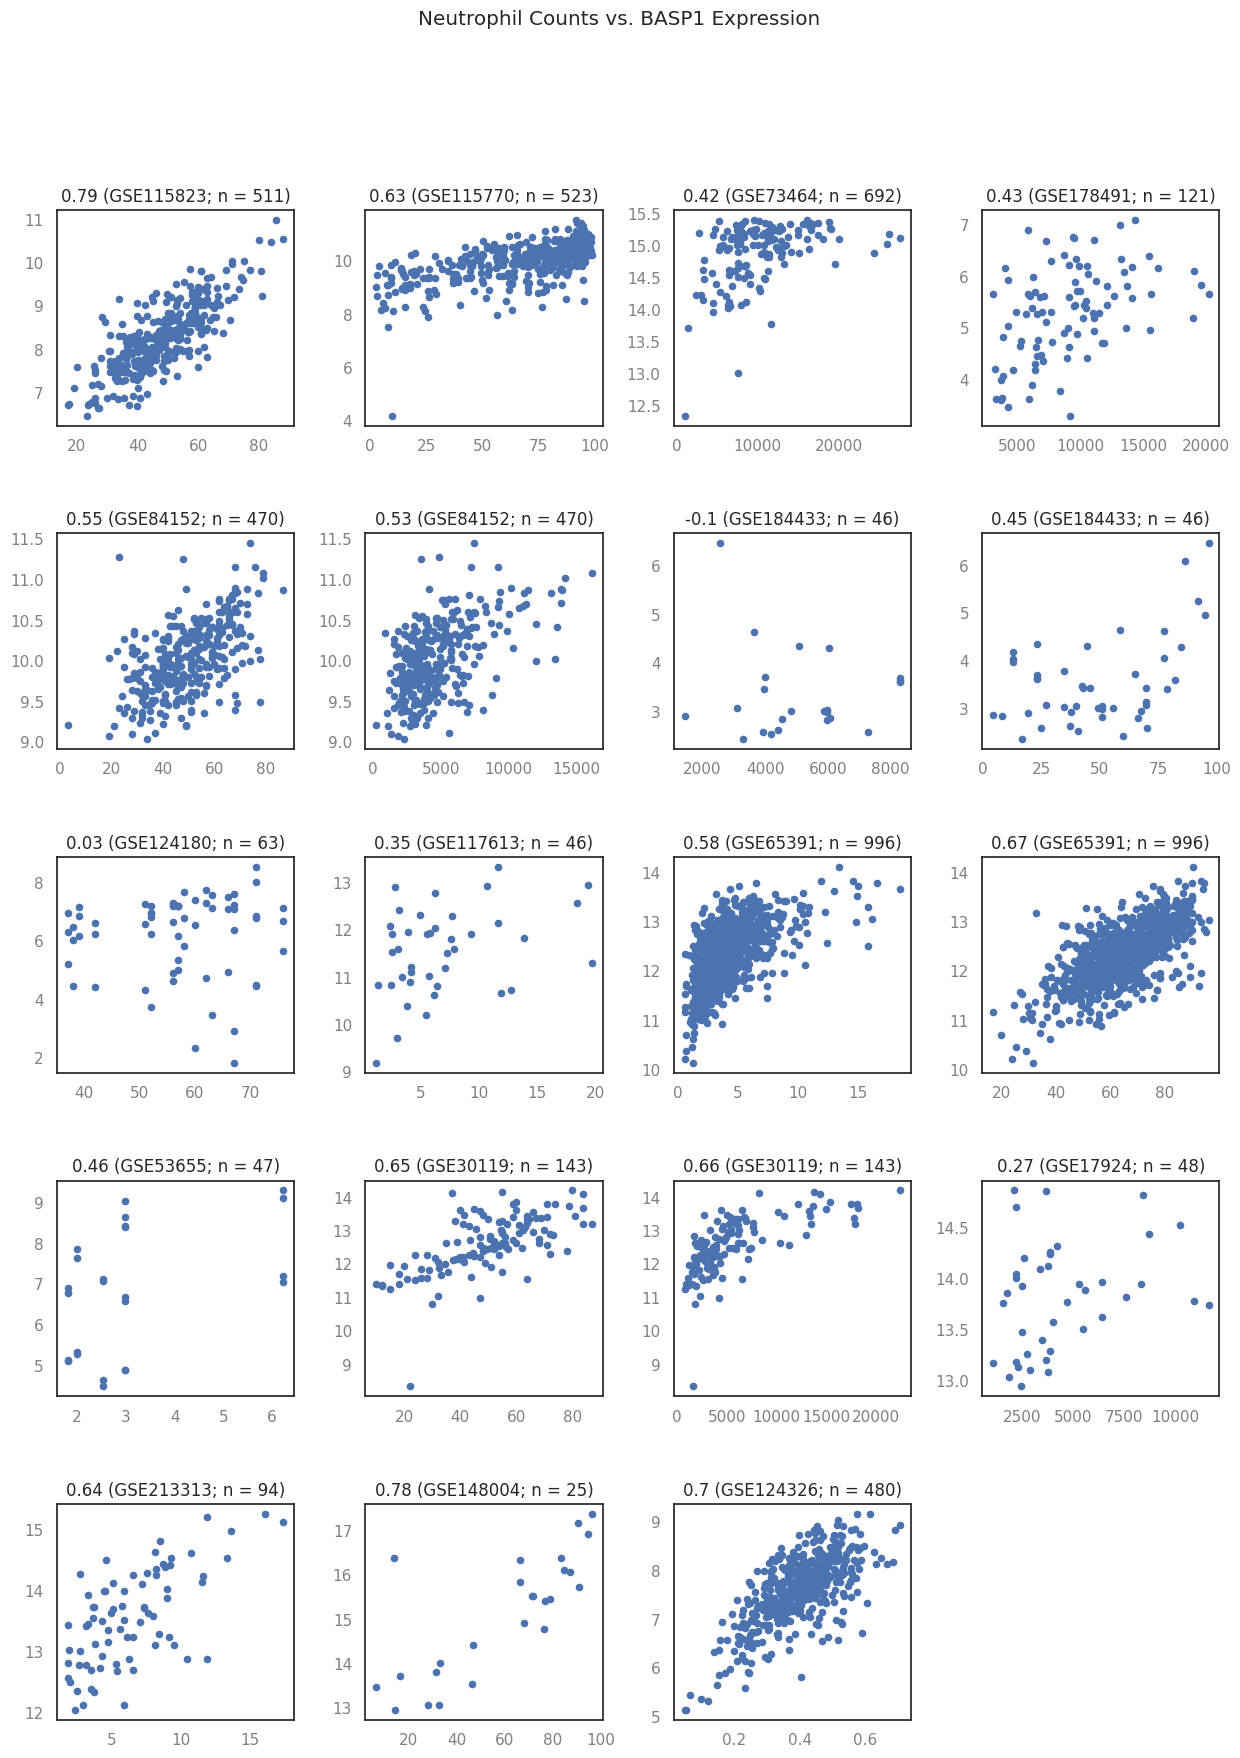

In [185]:
findCorr("BASP1", showplots=True, fname="Figures/basp1.pdf", save=True)

<a id="24"></a>

### 2.4 Outliers

There are some outliers, notably the Morrow 2019 copd dataset (MACV305, GSE124180, n = 63) which has low correlation. We can investigate it further and see that the dataset combines alveolar, bronchial and whole blood samples.

Morrow 2019 copd (n = 63)
GSE124180 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV305
0 [0, 0] GSE124180 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV305 MACV305
[5]


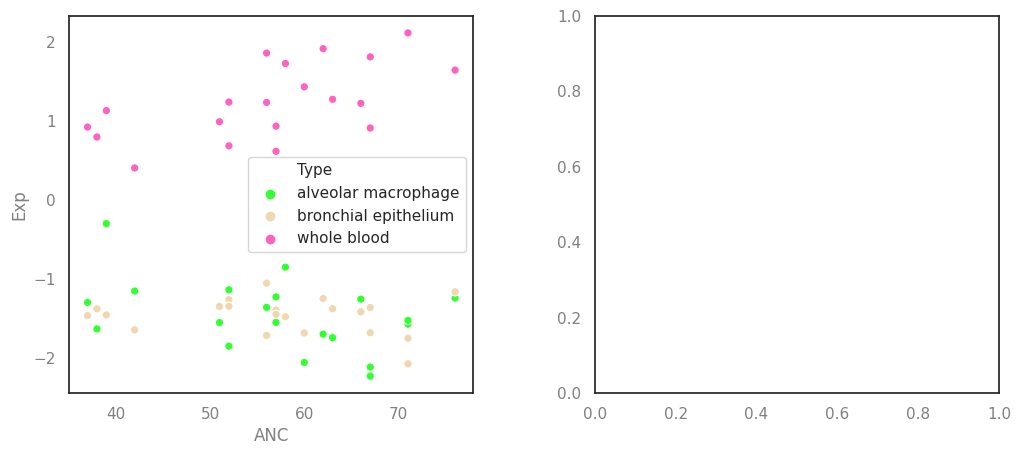

In [252]:
list1 = whole_dataset
dataset = list1[8]
ana = NeuAnalysis()
ana.getSurvival(dataset[0])
wbc = ana.h.getSurvName(dataset[1])
wt1, l1 = [1], [['KCNJ15', 'NAMPT', 'DYSF', 'BASP1', 'TNFRSF1A']]
ana.order = ana.h.aRange()
ana.orderData(l1, wt1)
expr = ["", ""] + list(ana.f_ranks)
df = pd.DataFrame()
ahash = {'NA':1, 'Not Applicable':1, 'Data Not Available':1,
         'unknown':1, 'Missing Data':1}
df['ANC'] = pd.to_numeric(["" if k.strip() in ahash else k for k in wbc[2:]])
df['Exp'] = pd.to_numeric(expr[2:])
atype = ana.h.getSurvName('c cell type')
df['Type'] = atype[2:]

fig,axs = plt.subplots(ncols=2, dpi=100)
fig.set_size_inches(12, 5)
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.5)

sns.scatterplot(data=df, x='ANC', y='Exp', hue='Type', ax=axs[0])

If we remove the other tissues and limit it to whole blood, the correlation is much higher. This indicates that some of the lower correlation observed could be due to similar annotation errors.

In [253]:
df = df[df['Type'] == 'whole blood']
#fig,ax = plt.subplots(figsize=(3,3), dpi=100)
df.plot.scatter('ANC', 'Exp', ax=axs[1], color='b')
print(ma.corrcoef(ma.masked_invalid(df['Exp']), ma.masked_invalid(df['ANC']))[0][1])

0.638865027124087


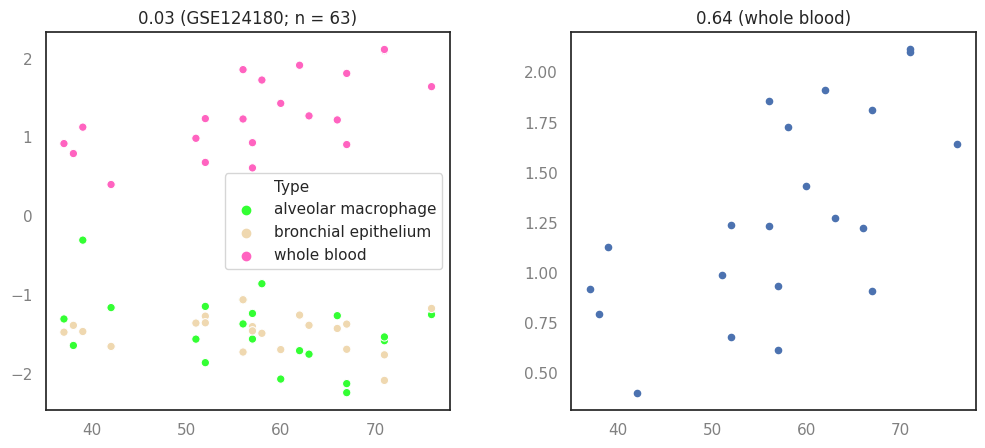

In [254]:
axs[0].set(title='0.03 (GSE124180; n = 63)', xlabel='', ylabel='')
axs[1].set(title='0.64 (whole blood)',xlabel='', ylabel='')
fig

In [255]:
pdf = PdfPages("Figures/outlier.pdf")
pdf.savefig(fig)
pdf.close()

Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
[5]
Altman 2019 asthma Nasal (n = 523)
GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192
0 [0, 0] GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192 COV192
[5]
Wright 2018 kd 2 (n = 692)
GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247
0 [0, 0] GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247 COV247
[8]
Burns 2020 kd tpm (n = 121)
GSE178491 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257
0 [0, 0] GSE178491 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257 COV257
[5]
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
[8]
Gideon 2016 tb (n = 470)
GSE

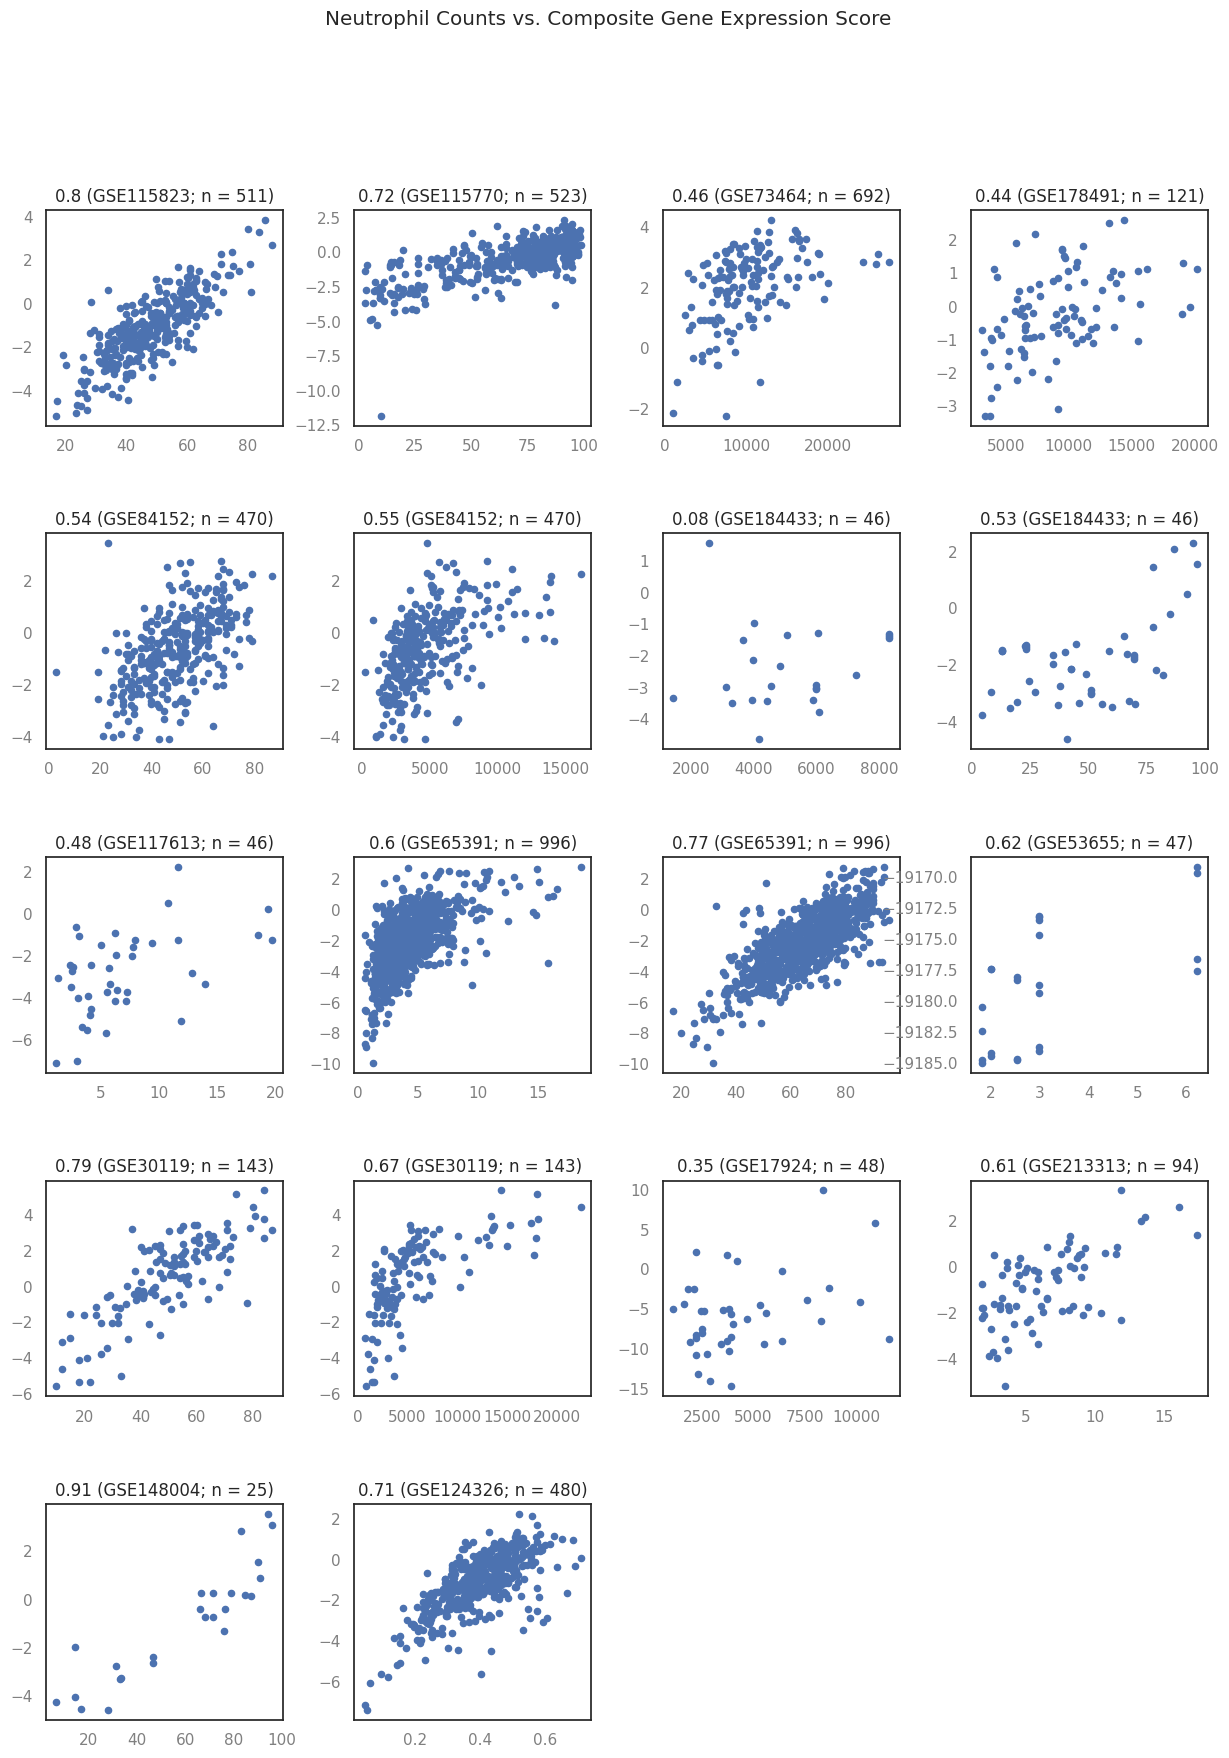

In [273]:
list1 = whole_dataset[0:8]+whole_dataset[9:]

res = {}
fig,axs = plt.subplots(nrows=5, ncols=4, dpi=100)
fig.set_size_inches(15, 20)
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.5)


for ax,id1 in zip(axs.flatten(), list1):
    
    ana = NeuAnalysis()
    ana.getSurvival(id1[0])
    wbc = ana.h.getSurvName(id1[1])
    wt1, l1 = [1], [['KCNJ15', 'NAMPT', 'DYSF', 'BASP1', 'TNFRSF1A']]
    ana.order = ana.h.aRange()
    ana.orderData(l1, wt1)
    expr = ["", ""] + list(ana.f_ranks)
    df = pd.DataFrame()
    ahash = {'NA':1, 'Not Applicable':1, 'Data Not Available':1,
             'unknown':1, 'Missing Data':1}
    df['ANC'] = pd.to_numeric(["" if k.strip() in ahash else k for k in wbc[2:]])
    df['Exp'] = pd.to_numeric(expr[2:])
    corr1 = ma.corrcoef(ma.masked_invalid(df['Exp']), ma.masked_invalid(df['ANC']))[0][1]
    res[id1[0]] = corr1

    h = hu.Hegemon(db.getDataset(id1[0]))
    name = h.getTitle().split("(")[1]
    title = f'{np.round(corr1, 2)} ({name}'
    df.plot.scatter('ANC', 'Exp', ax=ax, title=title, color='b')
    ax.set(xlabel=None, ylabel=None)

fig.suptitle(f"Neutrophil Counts vs. Composite Gene Expression Score")
fig.delaxes(axs[4,3])
fig.delaxes(axs[4,2])

pdf = PdfPages("Figures/compositev2.pdf")
pdf.savefig(fig)
pdf.close()

<a id="25"></a>

### 2.5 Specificity to neutrophils
We also verify that our list of 5 genes is specifically associated with neutrophil counts as opposed to other cell types such as macrophage, eosinophil, monocyte etc. counts.

In [258]:
datasets = [['MACV331', 'c diff cell count neutrophils (%)', 'Neutrophils'],
            ['MACV331', 'c diff cell count alveolar macrophages (%)', 'Alveolar Macrophages'],
            ['MACV331', 'c diff cell count eosinophils (%)', 'Eosinophils'],
            ['MACV331', 'c diff cell count lymphocytes (%)', 'Lymphocytes'],
            ['MACV331', 'c diff cell count ciliated cells (%)', 'Ciliated Cells'],
            ['MACV331', 'c diff cell count monocytes (%)', 'Monocytes'],
            ['MACV331', 'c diff cell count squamous cells (%)', 'Squamous Cells']]

Groth 2020 sputum (n = 25)
GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331
0 [0, 0] GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331 MACV331
[8]
Groth 2020 sputum (n = 25)
GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331
0 [0, 0] GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331 MACV331
[8]
Groth 2020 sputum (n = 25)
GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331
0 [0, 0] GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331 MACV331
[8]
Groth 2020 sputum (n = 25)
GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331
0 [0, 0] GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331 MACV331
[8]
Groth 2020 sputum (n = 25)
GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331
0 [0, 0] GSE148004 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV331 MACV331
[8]
Groth 2020 sputum (n = 25)
GSE148004 htt

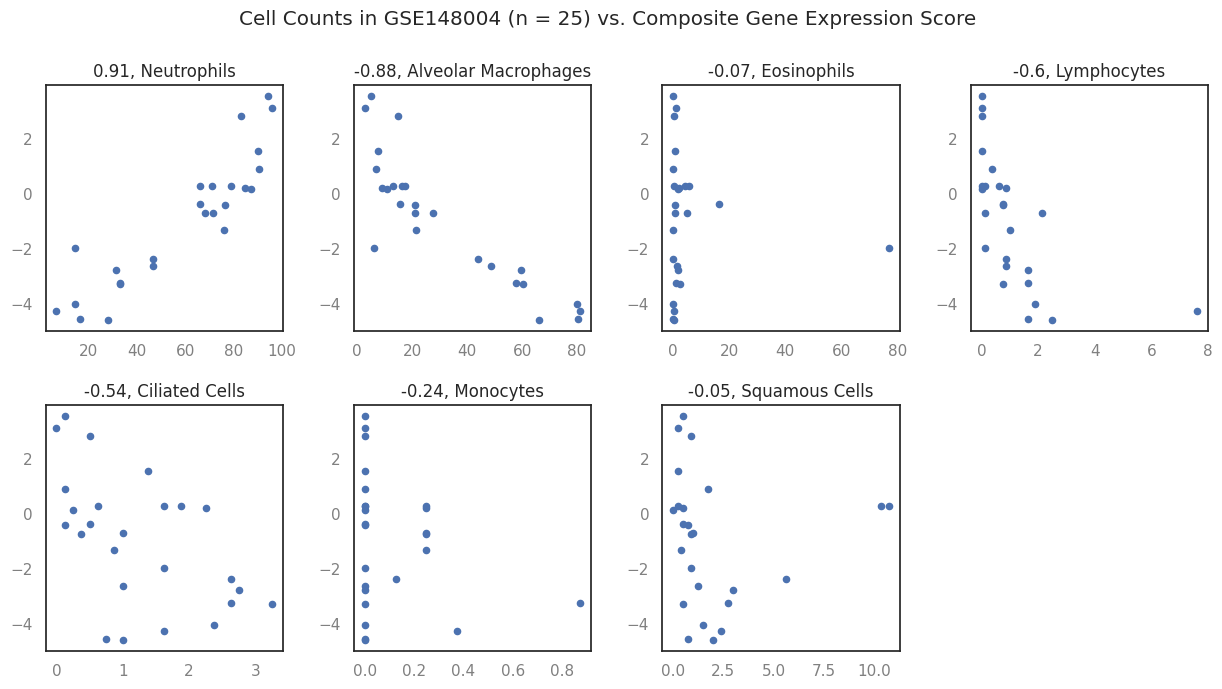

In [276]:
res = {}
fig,axs = plt.subplots(nrows=2, ncols=4, dpi=100)
fig.set_size_inches(15, 7.5)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for ax,id1 in zip(axs.flatten(), datasets):
    ana = NeuAnalysis()
    ana.getSurvival(id1[0])
    wbc = ana.h.getSurvName(id1[1])
    wt1, l1 = [1], [['KCNJ15', 'NAMPT', 'DYSF', 'BASP1', 'TNFRSF1A']]
    ana.order = ana.h.aRange()
    ana.orderData(l1, wt1)
    expr = ["", ""] + list(ana.f_ranks)
    df = pd.DataFrame()
    ahash = {'NA':1, 'Not Applicable':1, 'Data Not Available':1,
             'unknown':1, 'Missing Data':1}
    df['ANC'] = pd.to_numeric(["" if k.strip() in ahash else k for k in wbc[2:]])
    df['Exp'] = pd.to_numeric(expr[2:])
    corr1 = ma.corrcoef(ma.masked_invalid(df['Exp']), ma.masked_invalid(df['ANC']))[0][1]
    res[id1[1]] = corr1
    
    df.plot.scatter('ANC', 'Exp', ax=ax, title=f"{np.round(corr1,2)}, {id1[2]}", color='b')
    ax.set(xlabel=None, ylabel=None)

fig.suptitle("Cell Counts in GSE148004 (n = 25) vs. Composite Gene Expression Score")
fig.delaxes(axs[1,3])

pdf = PdfPages("Figures/celltypes.pdf")
pdf.savefig(fig)
pdf.close()

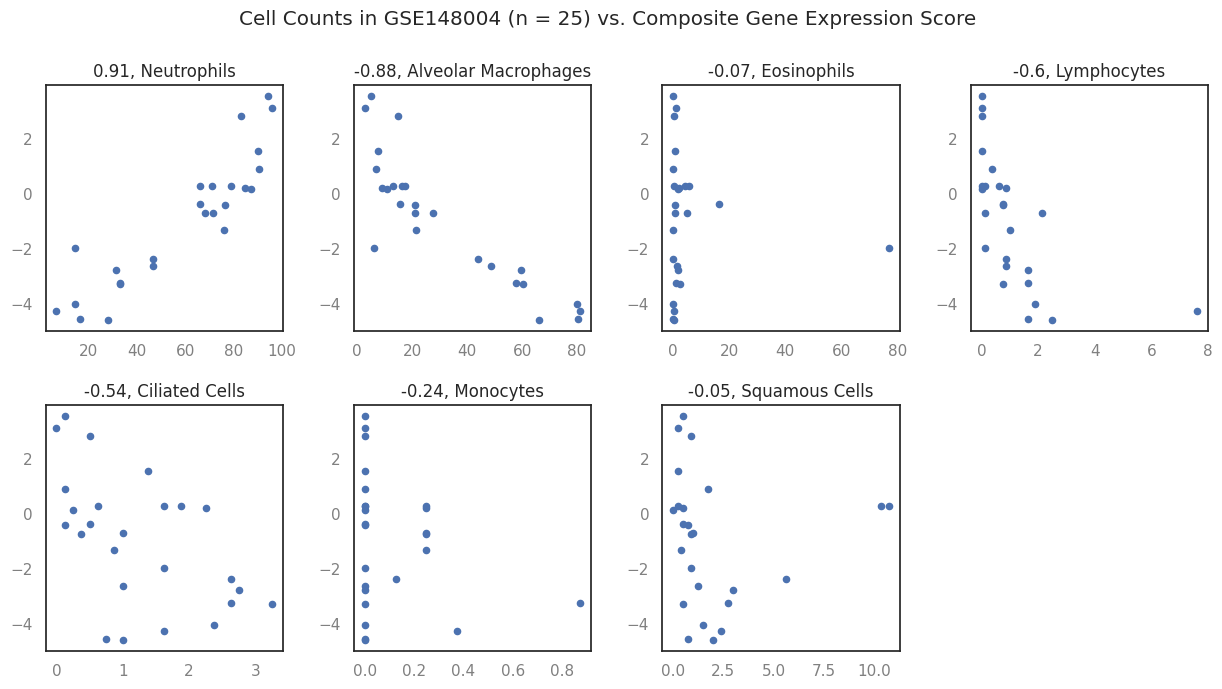

In [277]:
fig

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

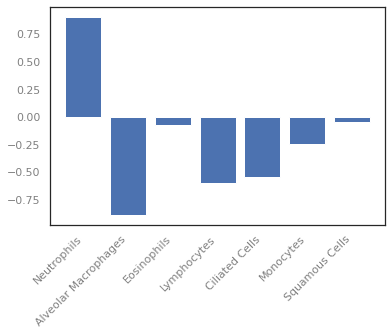

In [291]:
titles = [i[2] for i in datasets]
vals = list(res.values())
plt.bar(titles, vals, color='b')
plt.xticks(rotation=45, ha='right')

<a id="26"></a>

### 2.6 Predict Neutrophils

In [322]:
pdf = matplotlib.backends.backend_pdf.PdfPages("Figures/predict.pdf")

Jeffrey 2006 Mac Eos (n = 32)
GSE3982 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV52
32 [29, 3] GSE3982 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV52 MACV52
[7]


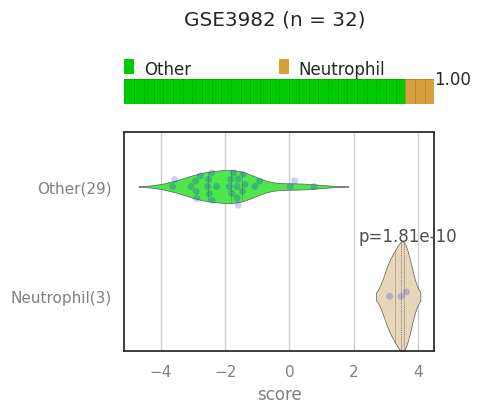

In [323]:
genes = ['KCNJ15', 'NAMPT', 'DYSF', 'BASP1', 'TNFRSF1A']
ana = NeuAnalysis()
ana.getJeffrey2006(tn=2)
fig = bone.processData(ana, [genes], [1], None, 1)
fig.suptitle('GSE3982 (n = 32)')
pdf.savefig(fig, bbox_inches='tight')

Jeffrey 2006 Mac Eos (n = 32)
GSE3982 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV52
32 [26, 3, 3] GSE3982 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV52 MACV52
[7]


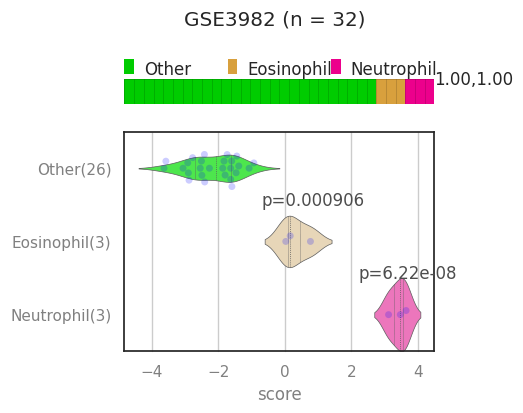

In [324]:
ana.getJeffrey2006(tn=3)
fig = bone.processData(ana, [genes], [1], None, 1)
fig.suptitle('GSE3982 (n = 32)')
pdf.savefig(fig, bbox_inches='tight')

Novershtern 2011 Human Hematopoiesis (n = 211)
GSE24759 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=G19
211 [203, 8] GSE24759 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=G19 G19
[5]


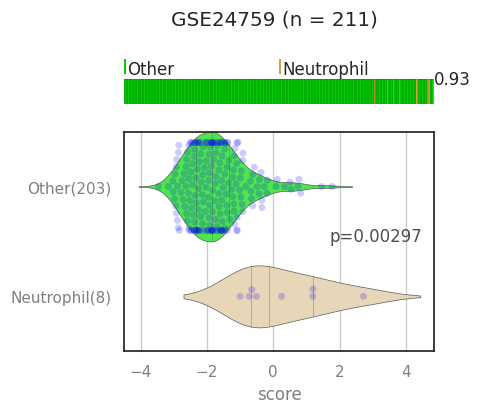

In [325]:
ana.getNorvershtern2011(tn=2)
fig = bone.processData(ana, [genes], [1], None, 1)
fig.suptitle('GSE24759 (n = 211)')
pdf.savefig(fig, bbox_inches='tight')

Monaco 2017 Immune Cells RNA-seq (n = 127)
GSE107011 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=NEU12
127 [123, 4] GSE107011 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=NEU12 NEU12
[5]


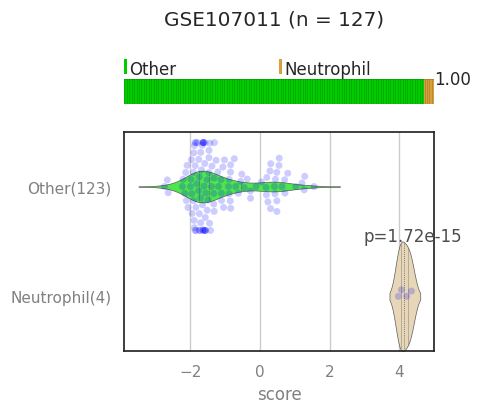

In [326]:
ana.getMonaco2017(tn=6)
fig = bone.processData(ana, [genes], [1], None, 1)
fig.suptitle('GSE107011 (n = 127)')
pdf.savefig(fig, bbox_inches='tight')

Allantaz 2011 Neu Eos (n = 33)
GSE28491 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=NEU6
33 [28, 5] GSE28491 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=NEU6 NEU6
[7]


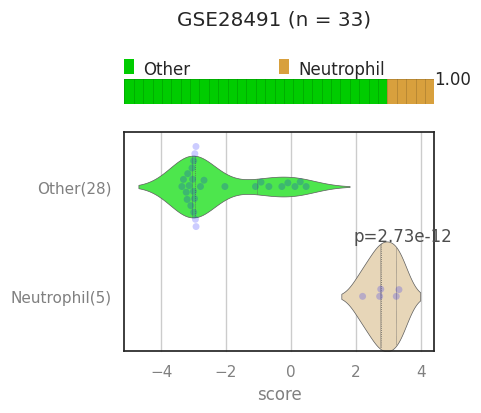

In [327]:
ana.getAllantaz2011(tn=2)
fig = bone.processData(ana, [genes], [1], None, 1)
fig.suptitle('GSE28491 (n = 33)')
pdf.savefig(fig, bbox_inches='tight')

In [328]:
pdf.close()

In [90]:
# Violin plot in Novershtern dataset
res = ['KCNJ15', 'NAMPT', 'DYSF', 'BASP1', 'TNFRSF1A']
h = getDataset("G19")
samples = getNorvershternSamples(tn=2)
testGenes(res, samples, tn=2, w=1.6, h=10, highlight="Neutrophil")

KCNJ15
Error or could not find KCNJ15
NAMPT
Error or could not find NAMPT
DYSF
Error or could not find DYSF
BASP1
Error or could not find BASP1
TNFRSF1A
Error or could not find TNFRSF1A


In [ ]:
# Violin plot in Novershtern dataset
h = getDataset("G19")
samples = getNorvershternSamples(tn=2)
testGenes(res, samples, tn=2, w=1.6, h=10, highlight="Neutrophil")

Altman 2019 asthma Nasal (n = 523)
GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192
0 [0, 0] GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192 COV192
Altman 2019 asthma Blood (n = 511)
GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2
0 [0, 0] GSE115823 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192.2 COV192.2
Wright 2018 kd 2 (n = 692)
GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247
0 [0, 0] GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247 COV247
Burns 2020 kd tpm (n = 121)
Burns http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257
0 [0, 0] Burns http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257 COV257
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.ed

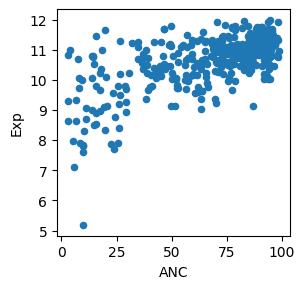

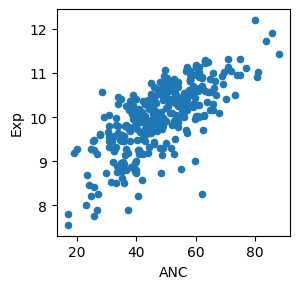

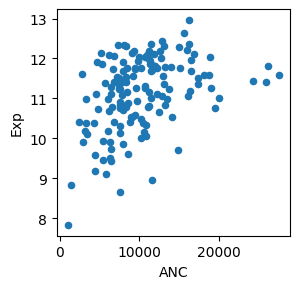

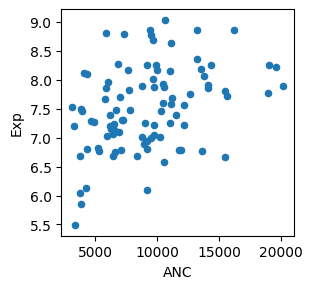

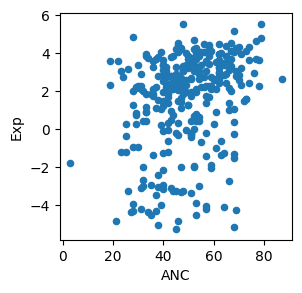

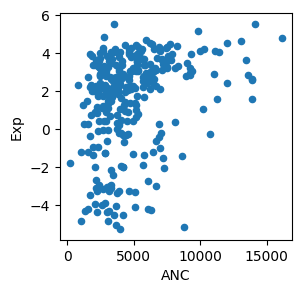

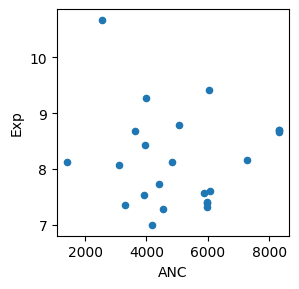

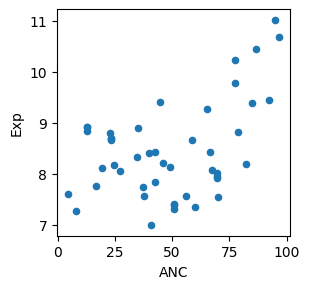

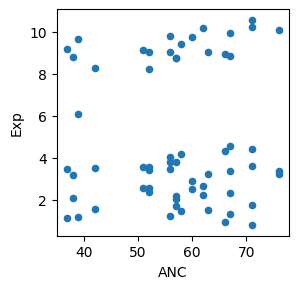

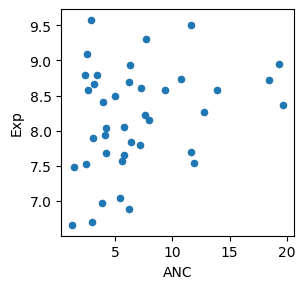

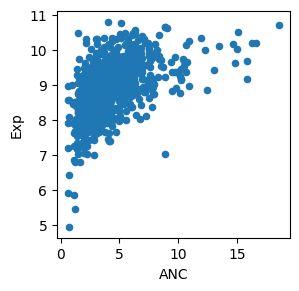

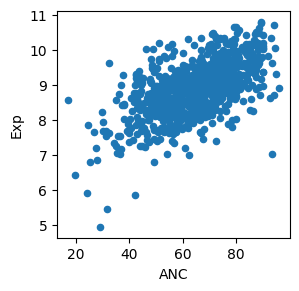

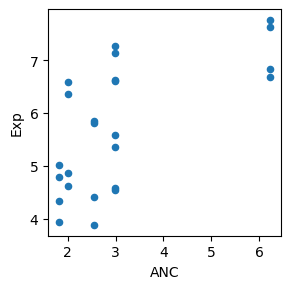

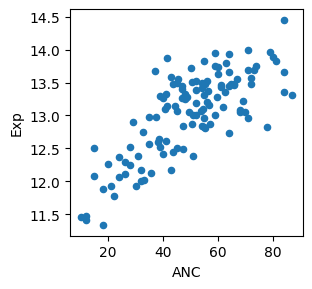

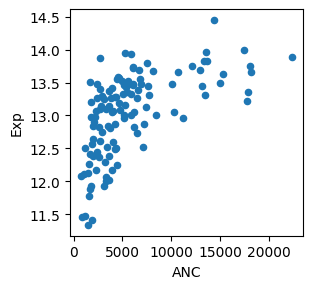

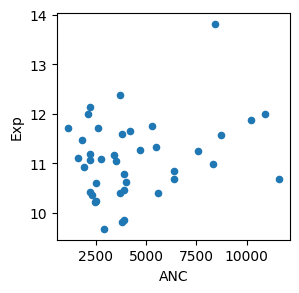

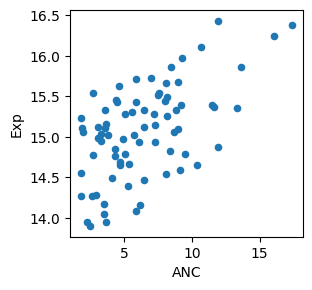

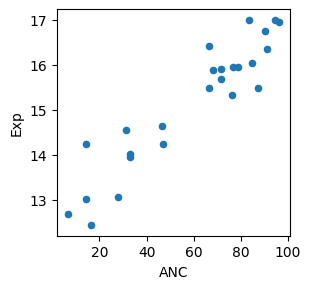

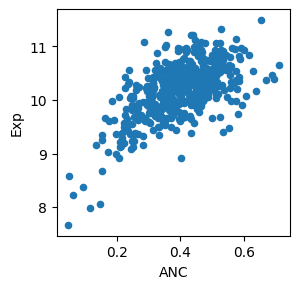

In [31]:
csf3rdict = findCorr("CSF3R", showplots=True)

In [34]:
np.mean(list(csf3rdict.values()))

0.4937989737201826

Altman 2019 asthma Nasal (n = 523)
GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192
0 [0, 0] GSE115770 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV192 COV192
[43]
Wright 2018 kd 2 (n = 692)
GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247
0 [0, 0] GSE73464 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV247 COV247
[47]
Burns 2020 kd tpm (n = 121)
Burns http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257
0 [0, 0] Burns http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV257 COV257
[27]
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
[47]
Gideon 2016 tb (n = 470)
GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314
0 [0, 0] GSE84152 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV314 COV314
[47]
Kho 2022 asthma (n = 46)
GSE184433 http://hegemon

0.5306075388075663

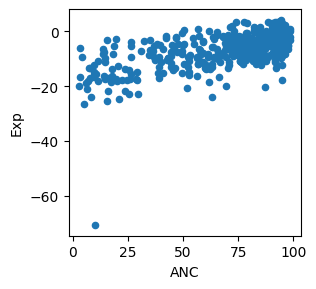

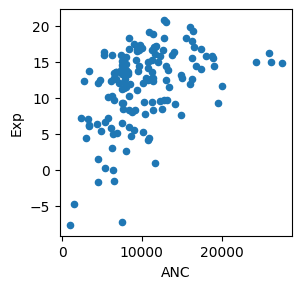

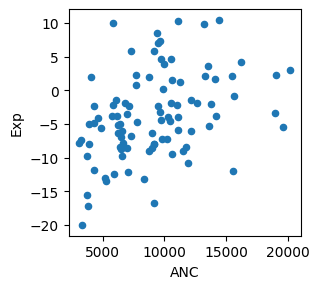

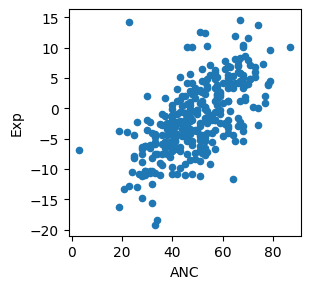

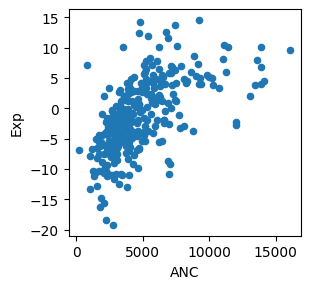

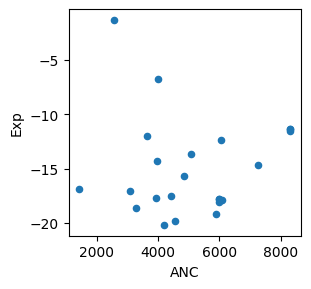

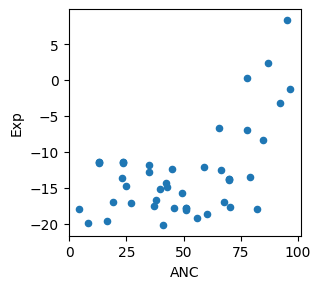

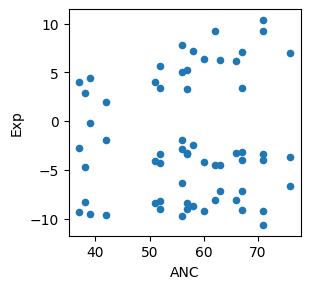

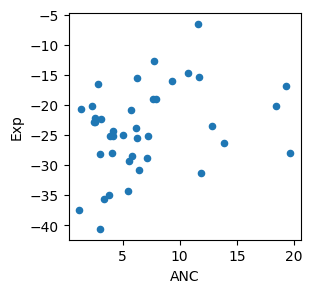

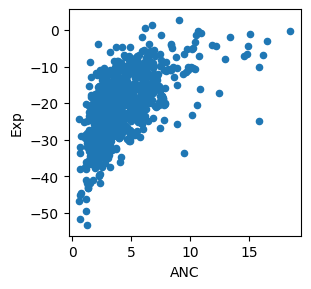

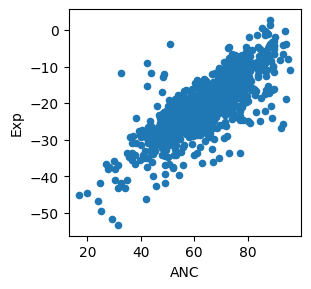

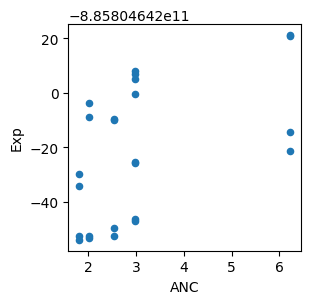

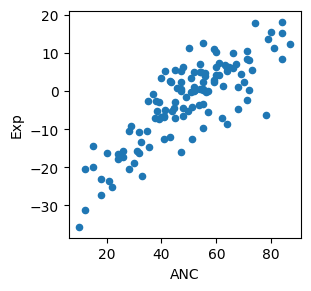

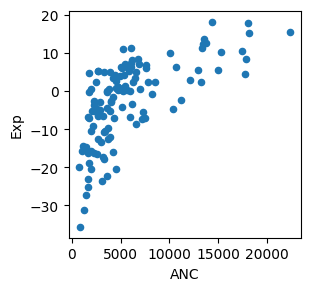

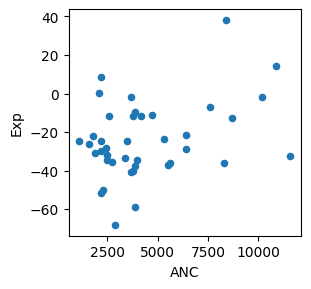

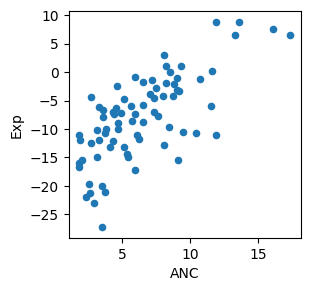

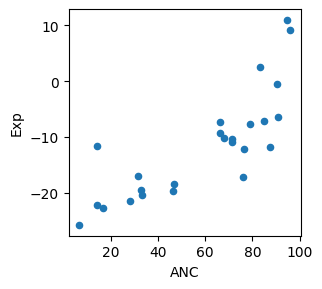

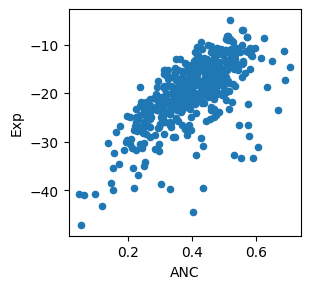

In [103]:
res = {}
lst = "KCNJ15 TLR4 FCGR3A PAK1 WDFY3 UBE2D1 FLJ11151 CLEC4E DOCK5 MEGF9 ABHD5 LIMK2 BCL6 IL13RA1 LST1 NAMPT GPR109B MBOAT7 DYSF OGFRL1 ARHGAP26 BASP1 PYGL TNFRSF1A HCK CFLAR NCF2 CEBPB MIRN21 BID"
lst = lst.split(" ")
for id1 in whole_dataset[1:]:
    ana = bone.IBDAnalysis()
    ana.getSurvival(id1[0])
    wbc = ana.h.getSurvName(id1[1])
    wt1, l1 = [1], [lst]
    ana.order = ana.h.aRange()
    ana.orderData(l1, wt1)
    expr = ["", ""] + list(ana.f_ranks)
    df = pd.DataFrame()
    ahash = {'NA':1, 'Not Applicable':1, 'Data Not Available':1,
             'unknown':1, 'Missing Data':1}
    df['ANC'] = pd.to_numeric(["" if k.strip() in ahash else k for k in wbc[2:]])
    df['Exp'] = pd.to_numeric(expr[2:])
    fig,ax = plt.subplots(figsize=(3,3), dpi=100)
    df.plot.scatter('ANC', 'Exp', ax=ax)
    corr1 = ma.corrcoef(ma.masked_invalid(df['Exp']), ma.masked_invalid(df['ANC']))[0][1]
    res[id1[0]] = corr1
np.mean(list(res.values()))

In [104]:
np.mean(list(res.values()))

0.5306075388075663